## Using `baseenv` environement

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.colors import LogNorm
from matplotlib.gridspec import GridSpec
import sys, os, glob, copy, time, subprocess
from datetime import datetime, timedelta

import healpy as hp
from uncertainties import ufloat
import astropy.units as u
from astropy.io import fits
from astropy.time import Time
from astropy.coordinates import SkyCoord, EarthLocation
from scipy.stats import norm
from scipy.optimize import curve_fit, root_scalar
from scipy.ndimage import gaussian_filter
from regions import CircleSkyRegion

from gammapy import __version__ as gammapy_version
from gammapy.irf import load_irf_dict_from_file
from gammapy.maps import MapAxis, WcsGeom, Map
from gammapy.data import DataStore, Observation, observatory_locations
from gammapy.makers import MapDatasetMaker, SafeMaskMaker, FoVBackgroundMaker, RingBackgroundMaker
from gammapy.datasets import Datasets, MapDataset, MapDatasetOnOff
from gammapy.estimators import ExcessMapEstimator, TSMapEstimator, FluxPointsEstimator
from gammapy.datasets.map import MapEvaluator
from gammapy.utils.deprecation import GammapyDeprecationWarning
from gammapy.stats.fit_statistics import cash
from gammapy.estimators.map.excess import convolved_map_dataset_counts_statistics
from gammapy.modeling.models import (
    LogParabolaSpectralModel, FoVBackgroundModel, GaussianSpatialModel,
    ConstantFluxSpatialModel, PiecewiseNormSpectralModel, PointSpatialModel,
    PowerLawSpectralModel, ConstantSpectralModel,
    LightCurveTemplateTemporalModel, GaussianTemporalModel,
    ConstantTemporalModel, ExpDecayTemporalModel, SkyModel, Models
)

import warnings, logging
warnings.filterwarnings("ignore", category=RuntimeWarning, append=True)
warnings.filterwarnings("ignore", category=GammapyDeprecationWarning)
warnings.filterwarnings("ignore", "Wswiglal-redir-stdio")
logging.getLogger("gammapy").setLevel(logging.ERROR)

import ligo.skymap.plot
from ligo.skymap.io.fits import read_sky_map

sys.path.insert(0, os.path.join(os.getcwd(), "../../../common/scripts/"))
import utils

observing_location = EarthLocation.of_site("Roque de los Muchachos")

print(f"Using Gammapy version: {gammapy_version}")

Using Gammapy version: 2.0


##### <span style="color:blue">Main parameters</span>

In [2]:
source_name = "S240615dg"

dir_dl3 = os.path.join(
    "/fefs/aswg/workspace/juan.jimenez/data/real", "mono", source_name, "v0.10.20", 
    "GammaDiffuse", "prod_standard", "DL3", "gh_dyn50"
)

source_coord = SkyCoord(ra=7.53, dec=45.81, unit="deg")

e_min, e_max, e_bins = 0.15 * u.TeV, 0.6 * u.TeV, 4.5

obs_ids = [17824] # [17822, 17823, 17824, 17825]

Other parameters

In [3]:
# --- Binning --- #
o_min, o_max, o_bins = 0 * u.deg, 2.5 * u.deg, 5 # Offset binning

# exclusion_regions = script.empty_exlusion_region

size_fov = 2.6 * u.deg

ring_r_in, ring_width = 0.35 * u.deg, 0.2 * u.deg

bkg_type = "baccmod" # baccmod or pybkgmodel

### <span style="color:blue">Reading GW data</span>

In [4]:
file_ligo = f"./data/gw_input/{source_name}.fits"

# Other parameters that can be changed but no need in principle
resolution_hp_to_grid = 2048 # Resolution of the HEALPix map to be used
threshold_percent_gw = np.flip(np.sort([0.95, 0.5])) # % of probabilities contours

ra_bins  = np.linspace(-180, 180, resolution_hp_to_grid)
dec_bins = np.linspace(-90, 90, resolution_hp_to_grid)
ra_grid, dec_grid = np.deg2rad(np.meshgrid(ra_bins, dec_bins))

data_ligo_hp, meta_ligo_hp = read_sky_map(file_ligo)
data_ligo_2d = utils.healpix2map(data_ligo_hp, ra_bins, dec_bins)
data_ligo_2d_smooth = gaussian_filter(data_ligo_2d, sigma=2)

# Getting the thresholds for probability containment
threshold_maps = utils.get_hp_map_thresholds(data_ligo_hp, threshold_percent_gw)

# Getting the coordinate of hottest spot
hotspot_coord = utils.get_2d_map_hotspot(data_ligo_2d, ra_bins, dec_bins)

### Defining the geometry (FoV, Energy axis, Spatial Binning)

Reco Energy axis edges:


<Quantity [0.15      , 0.23811016, 0.37797631, 0.6       ] TeV>

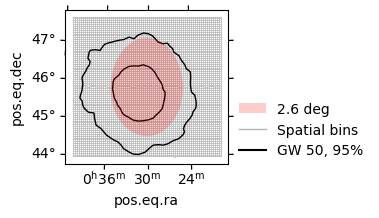

In [5]:
# Defining offset axis
axis_offset = MapAxis.from_bounds(o_min, o_max, nbin=o_bins, name="offset")
# Defining energy axis
axis_energy = MapAxis.from_energy_bounds(
    e_min, e_max, nbin=e_bins, per_decade=True, name="energy"
)
print(f"Reco Energy axis edges:"); display(axis_energy.edges)

geom_width = size_fov.value * 1.43, size_fov.value * 1.43
width, binsz = (geom_width), 0.05

npix = (int(width[0]/binsz), int(width[1]/binsz))

geom = WcsGeom.create(
    skydir = (source_coord.ra.degree, source_coord.dec.degree), 
    npix = npix, binsz = binsz, width = width, frame = "icrs",
    proj = "AIR", axes = [axis_energy],
)
geom_image = geom.to_image()

geom_centers = geom.get_coord(mode="center")
geom_edges = geom.get_coord(mode="edges")
bin_c_ra, bin_c_dec = geom_centers.lon[0].value, geom_centers.lat[0].value
bin_edges_ra, bin_edges_dec = geom_edges.lon[0].value, geom_edges.lat[0].value
bin_area = geom_image.solid_angle()

coord_array = SkyCoord(bin_c_ra, bin_c_dec, unit=u.deg)
separations_map = coord_array.separation(SkyCoord(*geom.center_coord)).deg

# Plotting geometry summary
utils.summary_geometry(geom, bin_edges_ra, bin_edges_dec, size_fov, data_ligo_2d, threshold_maps)

### <span style="color:blue">Converting the GW information into the WCS geometry</span>

In [6]:
pix_indices, nside = np.arange(len(data_ligo_hp)), hp.npix2nside(len(data_ligo_hp))
dec_hp, ra_hp = utils.IndexToDeclRa(pix_indices, nside)
hp_area = hp.nside2pixarea(nside)

# Reducing HealPix map to approx the WCS region
mask_hp_wcs = (
    (-(((ra_hp + 180) % 360) - 180) >= bin_edges_ra[:,-1:].min()) & (dec_hp >= bin_edges_dec[:1,:].max()) &
    (-(((ra_hp + 180) % 360) - 180) <= bin_edges_ra[:,:1].min()) & (dec_hp <= bin_edges_dec[-1:,:].max())
)
data_ligo_hp_wcs = data_ligo_hp[mask_hp_wcs]
dec_hp_wcs, ra_hp_wcs = dec_hp[mask_hp_wcs], -(ra_hp[mask_hp_wcs] + 180) % 360 - 180

# Now we integrate the probability for every bin in WCS
prob_gw_integrated = np.zeros((len(bin_edges_ra)-1, len(bin_edges_dec)-1))
num_hp_pixels = np.zeros((len(bin_edges_ra)-1, len(bin_edges_dec)-1))
mask_already_added_pixels = np.repeat(False, len(ra_hp_wcs))
for i in range(len(bin_edges_ra)-1):
    for j in range(len(bin_edges_ra[i])-1):
        mask_bin = (
            (ra_hp_wcs >= bin_edges_ra[i,j+1]) & (dec_hp_wcs >= bin_edges_dec[i,j]) &
            (ra_hp_wcs <= bin_edges_ra[i,j]) & (dec_hp_wcs <= bin_edges_dec[i+1,j+1])
        ) * (~mask_already_added_pixels)
        
        p = np.sum(data_ligo_hp_wcs[mask_bin]) * (
            bin_area[i,j].value / (np.sum(mask_bin) * hp_area)
        )
        prob_gw_integrated[i, j] = 0.0 if np.isnan(p) else p
        num_hp_pixels[i, j] = np.sum(mask_bin)

        mask_already_added_pixels = (mask_already_added_pixels | mask_bin)

norm_factor_gammapy_region = np.sum(prob_gw_integrated.ravel())
print(f"Geometry covers {norm_factor_gammapy_region * 100:.2f}% of the GW")

prob_gw = prob_gw_integrated
log_gw = 2 * np.log10(prob_gw)

masks_thresholds = []
for level in threshold_maps:
    paths = plt.contour(
        np.rad2deg(ra_grid), np.rad2deg(dec_grid),
        np.flip(data_ligo_2d, axis=1), levels=[level]
    ).collections[0].get_paths(); plt.close()

    ra_wrapped = -((bin_c_ra + 180) % 360) + 180
    mask = [[any(p.contains_point((ra_wrapped[i, j], bin_c_dec[i, j])) for p in paths)
             for j in range(bin_c_ra.shape[1])]
            for i in range(bin_c_ra.shape[0])]

    masks_thresholds.append(np.array(mask))
    
for i in range(len(threshold_percent_gw)):
    mask = masks_thresholds[i]
    prob_contained = np.sum(prob_gw[mask])/threshold_percent_gw[i]*100
    print(f" - For {threshold_percent_gw[i]*100}% of GW, Geom contains ~{prob_contained:.2f}% of the total.")

Geometry covers 99.27% of the GW


/tmp/ipykernel_18303/326329849.py:43: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed in 3.10.
  ).collections[0].get_paths(); plt.close()


 - For 95.0% of GW, Geom contains ~99.99% of the total.
 - For 50.0% of GW, Geom contains ~99.69% of the total.


### Reading the DL3 data and adding BKG hdu

In [7]:
data_store_real = DataStore.from_dir(dir_dl3)
print(f"Obs IDs in directory: {data_store_real.obs_ids}\n")

obs_collection_real = data_store_real.get_observations(
    obs_id = obs_ids, required_irf = ["aeff", "edisp"] # "psf"
)
obs_collection_real = utils.add_telescope_location_to_obs(obs_collection_real, observing_location)

# Reading background IRF information and adding it to the information
data_store_real.hdu_table.remove_rows(data_store_real.hdu_table["HDU_TYPE"]=="bkg")
for obs_id in obs_ids:
    data_store_real = utils.read_bkg(data_store_real, obs_id, dir_dl3, dim_bkg=3, bkg_type=bkg_type)

data_store_real.hdu_table = data_store_real.hdu_table.copy() # Copy the table to update the data
obs_collection_real = data_store_real.get_observations(
    obs_id=obs_ids, required_irf=["aeff", "edisp", "psf"]
)
obs_collection_real = utils.add_telescope_location_to_obs(obs_collection_real, observing_location)

obs_table = data_store_real.obs_table[np.isin(data_store_real.obs_table["OBS_ID"], obs_ids)]
hdu_table = data_store_real.hdu_table[np.isin(data_store_real.hdu_table["OBS_ID"], obs_ids)]
print(f"Total livetime : {obs_table['LIVETIME'].to(u.min).sum():.2f}\n"); display(hdu_table)

Obs IDs in directory: [17820 17821 17822 17823 17824 17825]



AttributeError: 'Observation' object has no attribute 'obs_info'

#### Showing summaries for all the data + IRFs inside the DL3

In [ ]:
obs = obs_collection_real[0]
print("EVENTS SUMMARY:"); obs.events.peek(); plt.show()
print("EFFECTIVE AREA SUMMARY:"); obs.aeff.peek(figsize=(9, 2.7)); plt.show()
print("ENERGY DISPERSION SUMMARY:"); obs.edisp.peek(figsize=(9, 2.7)); plt.show()
print("PSF SUMMARY:"); obs.psf.peek(figsize=(9, 2.7)); plt.show()
print("BACKGROUND SUMMARY:"); obs.bkg.peek(figsize=(7, 5)); plt.show()

#### We run the pipeline for the real data to compare

In [ ]:
maker = MapDatasetMaker(selection=["counts", "background", "psf", "edisp", "exposure"])
# maker_safe_mask = SafeMaskMaker(methods=["aeff-default"])
maker_safe_mask = SafeMaskMaker(methods=["offset-max"], offset_max=size_fov)
maker_ring = RingBackgroundMaker(r_in=ring_r_in, width=ring_width)

# dataset_empty = MapDataset.create(geom, energy_axis_true=axis_energy_true)
# stacked_dataset_ring = MapDatasetOnOff.create(geom, energy_axis_true=axis_energy_true)
dataset_empty = MapDataset.create(geom)
dataset_stacked_real = MapDatasetOnOff.create(geom)
datasets_real, bkg_models = [], []

for i, obs in enumerate(obs_collection_real[:]):
    dataset = maker.run(dataset_empty.copy(), obs)
    dataset = maker_safe_mask.run(dataset, obs)
    dataset_on_off = maker_ring.run(dataset)
    
    datasets_real.append(dataset_on_off)
    dataset_stacked_real.stack(dataset_on_off)
    
    utils.summary_folded_counts(dataset_on_off, bin_c_ra, obs, i, len(obs_collection_real))
    
    # Storing the NORMALIZED bkg model
    bkg_models.append(dataset_on_off.background.copy())

datasets_all_real = Datasets(datasets_real)
    
# stacked_dataset_ring.peek(figsize=(7, 6))
utils.summary_maps(
    datasets_real[0], geom, bin_edges_ra, bin_edges_dec, data_ligo_2d, 
    threshold_maps, source_coord, source_name
)

### Getting IRFs, pointing, and timing information from real data

In [ ]:
# Getting the IRFs for each observation
obs_irfs, obs_time_ref, obs_pointing, obs_livetime = [], [], [], []
for i, obs_id in enumerate(obs_ids):
    hdu_tab = data_store_real.hdu_table[data_store_real.hdu_table["OBS_ID"] == obs_id]
    obs_tab = data_store_real.obs_table[data_store_real.obs_table["OBS_ID"] == obs_id]
    
    path_dl3 = os.path.join(dir_dl3, hdu_tab[hdu_tab["HDU_NAME"] == "EVENTS"]["FILE_NAME"][0])
    path_bkg = os.path.join(dir_dl3, hdu_tab[hdu_tab["HDU_NAME"] == "BACKGROUND"]["FILE_NAME"][0])
    
    _irfs_, _irf_bkg_ = load_irf_dict_from_file(path_dl3), load_irf_dict_from_file(path_bkg)
    _irfs_.update(_irf_bkg_)

    obs_irfs.append(_irfs_)
    obs_time_ref.append(Time(f"{obs_tab['DATE-OBS'][0]} {obs_tab['TIME-OBS'][0]}", scale="utc"))
    obs_pointing.append(SkyCoord(ra=obs_tab["RA_PNT"][0], dec=obs_tab["DEC_PNT"][0], unit=u.deg, frame="icrs"))
    obs_livetime.append(np.sum(obs_tab["LIVETIME"]))
    print(f"Run {obs_id}\n - IRFs: {list(_irfs_.keys())}\n - Livetime {obs_livetime[-1]/60:.2f} min")
    print(f" - Time Ref {obs_time_ref[-1]}")
    print(f" - Pointing (RA={obs_tab['RA_PNT'][0]:.2f}, DEC={obs_tab['DEC_PNT'][0]:.2f})deg")

#### Setting the model for BKG + possible source

In [125]:
A = 5e-11
pwl_bkg = PowerLawSpectralModel(
    amplitude=A * u.Unit("TeV-1 s-1 cm-2"), index=2
)
flux_A = pwl_bkg.integral(*axis_energy.edges[[0, -1]])
print(flux_A)

2.5e-10 1 / (s cm2)


In [126]:
# Setting the models
model_source = SkyModel(
    spatial_model = PointSpatialModel.from_position(source_coord),
    spectral_model = PowerLawSpectralModel(
        index=2, amplitude=f"0 cm-2 s-1 TeV-1", reference="1 TeV"
    ),
    temporal_model = ConstantTemporalModel(const=1),
    name="model-simulated",
)
models_simulated = Models([model_source])

model_f = SkyModel(
    spatial_model = PointSpatialModel.from_position(source_coord),
    spectral_model = PowerLawSpectralModel(
        index=2, amplitude=f"{A} cm-2 s-1 TeV-1", reference="1 TeV"
    ),
    temporal_model = ConstantTemporalModel(const=1),
    name="model-flux",
)
models_f = Models([model_f])

#### Generating the Observations object and filling it with BKG (we can fill it with `.fake()`)

In [127]:
observations = [Observation.create(
    obs_id = f"{i}",
    pointing = obs_pointing[i], 
    livetime = obs_livetime[i] * u.s, 
    irfs = obs_irfs[i], 
    location = observing_location,
    reference_time = obs_time_ref[i],
) for i in range(len(obs_irfs))]

maker = MapDatasetMaker(selection=["background", "psf", "edisp", "exposure"])
# maker_safe_mask = SafeMaskMaker(methods=["aeff-default"])
maker_safe_mask = SafeMaskMaker(methods=["offset-max"], offset_max=size_fov)

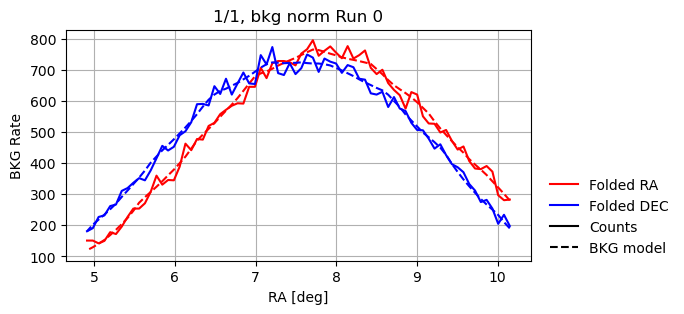

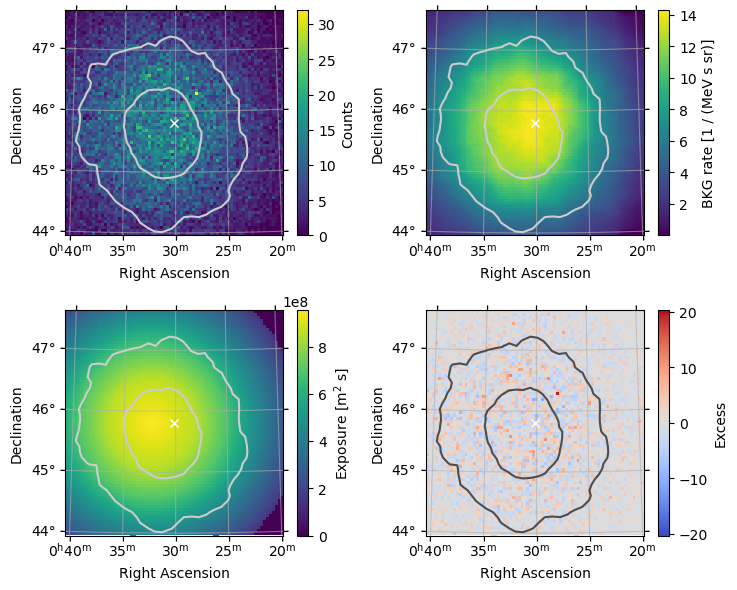

In [128]:
dataset_empty = MapDataset.create(geom) #, name="dataset-simulated", energy_axis_true=axis_energy_true)
dataset_stacked_simulated = MapDataset.create(geom)
dataset_stacked_simulated_f = MapDataset.create(geom)

datasets_simulated   = []
datasets_simulated_f = []
for i, obs in enumerate(observations):
    dataset = maker.run(dataset_empty.copy(), obs)
    dataset = maker_safe_mask.run(dataset, obs)
    dataset_f = maker.run(dataset_empty.copy(), obs)
    dataset_f = maker_safe_mask.run(dataset_f, obs)
    
    # Setting the model and the background
    dataset.models = models_simulated
    dataset.background = bkg_models[i]
    dataset_f.models = models_f
    dataset_f.background = bkg_models[i]
    
    dataset.fake(random_state=i+4)
    dataset_f.fake(random_state=i+4)
    
    datasets_simulated.append(dataset)
    datasets_simulated_f.append(dataset_f)
    dataset_stacked_simulated.stack(dataset)
    dataset_stacked_simulated_f.stack(dataset_f)
    
    utils.summary_folded_counts(dataset, bin_c_ra, obs, i, len(observations))

datasets_all_simulated = Datasets(datasets_simulated)
datasets_all_simulated_f = Datasets(datasets_simulated_f)

# datasets_simulated[0].peek(figsize=(7, 6))
utils.summary_maps(
    datasets_simulated[0], geom, bin_edges_ra, bin_edges_dec, data_ligo_2d, 
    threshold_maps, source_coord, source_name
)

### Comparison counts data-simulations

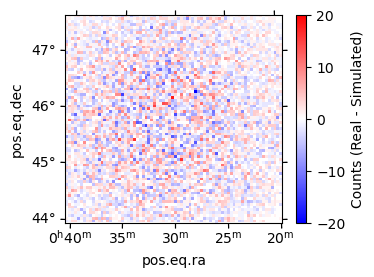

In [129]:
fig, (ax1) = plt.subplots(1, 1, figsize=(3.5, 2.7), subplot_kw={"projection": geom.wcs})

data = datasets_real[0].counts.data.sum(axis=0)-datasets_simulated[0].counts.data.sum(axis=0)
p_diff = ax1.pcolormesh(
    bin_edges_ra, bin_edges_dec, data, vmin=-np.abs(data).max(), vmax=np.abs(data).max(),
    cmap="bwr", transform=ax1.get_transform("icrs"), # norm=LogNorm()
); fig.colorbar(p_diff, ax=ax1, label="Counts (Real - Simulated)")

plt.show()

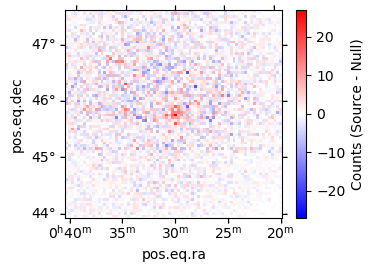

In [130]:
fig, (ax1) = plt.subplots(1, 1, figsize=(3.5, 2.7), subplot_kw={"projection": geom.wcs})

data = datasets_simulated_f[0].counts.data.sum(axis=0)-datasets_simulated[0].counts.data.sum(axis=0)
p_diff = ax1.pcolormesh(
    bin_edges_ra, bin_edges_dec, data, vmin=-np.abs(data).max(), vmax=np.abs(data).max(),
    cmap="bwr", transform=ax1.get_transform("icrs"), # norm=LogNorm()
); fig.colorbar(p_diff, ax=ax1, label="Counts (Source - Null)")

plt.show()

## Datasets created. Now estimating flux +  significances

In [131]:
print(f"Energy axis edges:"); display(axis_energy.edges)
estimator_type = "ts" # "ts" or "excess"

Energy axis edges:


<Quantity [0.15      , 0.23811016, 0.37797631, 0.6       ] TeV>

In [132]:
%%time
energy_edges = [axis_energy.edges[0], axis_energy.edges[-1]]
    
spatial_model = PointSpatialModel(lon_0=source_coord.ra, lat_0=source_coord.dec)
spectral_model = PowerLawSpectralModel(index=2) # utils.crab_model_1.spectral_model.copy() # 
model = SkyModel(spatial_model=spatial_model, spectral_model=spectral_model)

excess_estimator = ExcessMapEstimator(
    correlation_radius = 0.1 * u.deg,
    correlate_off = True, # Default True
    spectral_model = spectral_model,
    energy_edges = energy_edges,
    selection_optional = "all",
)

# In order to run the estimator over the ring dataset we need 
# to use "excess_estimator", as "ts_estimator" is not compatible
maps_real = excess_estimator.run(dataset_stacked_real)
maps_simulated = excess_estimator.run(dataset_stacked_simulated)
maps_simulated_f = excess_estimator.run(dataset_stacked_simulated_f)

CPU times: user 49 s, sys: 568 ms, total: 49.6 s
Wall time: 49.7 s


In [133]:
a = excess_estimator.estimate_kernel(dataset)

a.data

array([[0.        , 0.        , 0.07692308, 0.        , 0.        ],
       [0.        , 0.07692308, 0.07692308, 0.07692308, 0.        ],
       [0.07692308, 0.07692308, 0.07692308, 0.07692308, 0.07692308],
       [0.        , 0.07692308, 0.07692308, 0.07692308, 0.        ],
       [0.        , 0.        , 0.07692308, 0.        , 0.        ]])

Significance: 10.02 sigma


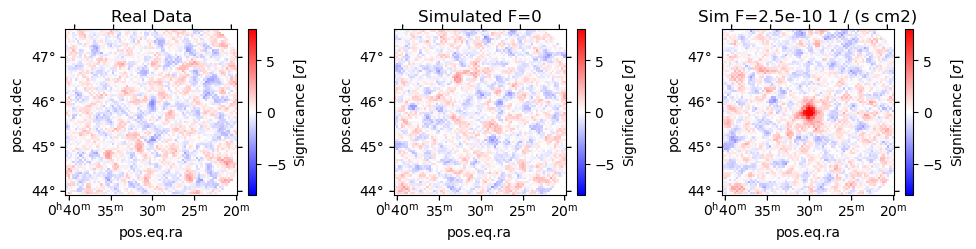

In [134]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(10, 2.6), subplot_kw={"projection": geom.wcs})

a1 = ax1.pcolormesh(
    bin_edges_ra, bin_edges_dec, maps_real.sqrt_ts.data[0],
    transform=ax1.get_transform("icrs"), vmin=-8, vmax=8, cmap="bwr"
)
a2 = ax2.pcolormesh(
    bin_edges_ra, bin_edges_dec, maps_simulated.sqrt_ts.data[0], 
    transform=ax2.get_transform("icrs"), vmin=-8, vmax=8, cmap="bwr"
)
a3 = ax3.pcolormesh(
    bin_edges_ra, bin_edges_dec, maps_simulated_f.sqrt_ts.data[0], 
    transform=ax3.get_transform("icrs"), vmin=-8, vmax=8, cmap="bwr"
)
fig.colorbar(a1, ax=ax1, label="Significance [$\sigma$]"); ax1.set_title("Real Data")
fig.colorbar(a2, ax=ax2, label="Significance [$\sigma$]"); ax2.set_title("Simulated F=0")
fig.colorbar(a3, ax=ax3, label="Significance [$\sigma$]"); ax3.set_title(f"Sim F={flux_A:.1e}")
plt.tight_layout()
print(f"Significance: {np.nanmax(maps_simulated_f.sqrt_ts.data[0]):.2f} sigma")
plt.show()

Center Flux UL = 9.03e-11 1 / (s cm2)


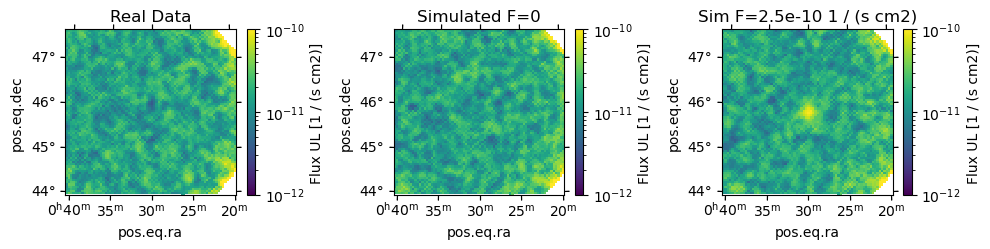

In [135]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(10, 2.6), subplot_kw={"projection": geom.wcs})

a1 = ax1.pcolormesh(
    bin_edges_ra, bin_edges_dec, maps_real.flux_ul.data[0], cmap="viridis",
    transform=ax1.get_transform("icrs"), norm=LogNorm(vmin=1e-12, vmax=1e-10)
)
a2 = ax2.pcolormesh(
    bin_edges_ra, bin_edges_dec, maps_simulated.flux_ul.data[0],
    transform=ax2.get_transform("icrs"), norm=LogNorm(vmin=1e-12, vmax=1e-10)
)
a3 = ax3.pcolormesh(
    bin_edges_ra, bin_edges_dec, maps_simulated_f.flux_ul.data[0], 
    transform=ax3.get_transform("icrs"), norm=LogNorm(vmin=1e-12, vmax=1e-10)
)
fig.colorbar(a1, ax=ax1, label="Flux UL [1 / (s cm2)]"); ax1.set_title("Real Data")
fig.colorbar(a2, ax=ax2, label="Flux UL [1 / (s cm2)]"); ax2.set_title("Simulated F=0")
fig.colorbar(a3, ax=ax3, label="Flux UL [1 / (s cm2)]"); ax3.set_title(f"Sim F={flux_A:.1e}")
plt.tight_layout()

c_f_ul = maps_simulated_f.flux_ul.data[0][*np.array(maps_simulated_f.flux_ul.data[0].shape)//2]
print(f"Center Flux UL = {c_f_ul:.2e} 1 / (s cm2)")
plt.show()

Max Flux = 7.12e-11 1 / (s cm2)


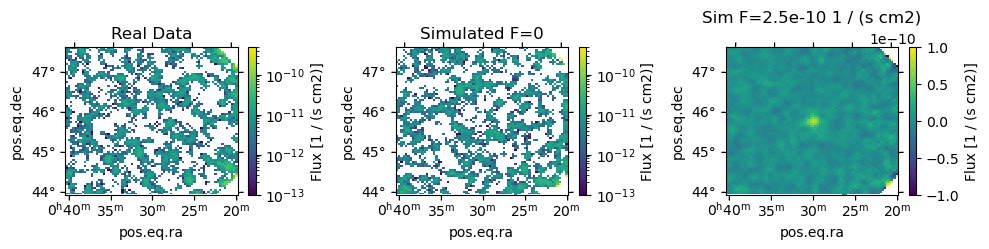

In [140]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(10, 2.6), subplot_kw={"projection": geom.wcs})

a1 = ax1.pcolormesh(
    bin_edges_ra, bin_edges_dec, maps_real.flux.data[0], cmap="viridis",
    transform=ax1.get_transform("icrs"), norm=LogNorm(vmin=1e-13, vmax=5e-10)
)
a2 = ax2.pcolormesh(
    bin_edges_ra, bin_edges_dec, maps_simulated.flux.data[0], 
    transform=ax2.get_transform("icrs"), norm=LogNorm(vmin=1e-13, vmax=5e-10)
)
a3 = ax3.pcolormesh(
    bin_edges_ra, bin_edges_dec, maps_simulated_f.flux.data[0], 
    transform=ax3.get_transform("icrs"), vmin=-1e-10, vmax=1e-10
)
fig.colorbar(a1, ax=ax1, label="Flux [1 / (s cm2)]"); ax1.set_title("Real Data")
fig.colorbar(a2, ax=ax2, label="Flux [1 / (s cm2)]"); ax2.set_title("Simulated F=0")
fig.colorbar(a3, ax=ax3, label="Flux [1 / (s cm2)]"); ax3.set_title(f"Sim F={flux_A:.1e}\n")
plt.tight_layout()

c_f = maps_simulated_f.flux.data[0][*np.array(maps_simulated_f.flux.data[0].shape)//2]
print(f"Max Flux = {c_f:.2e} 1 / (s cm2)")
plt.show()

In [139]:
2.98e-06, 9.35e-05

(2.98e-06, 9.35e-05)

In [137]:
D

<Quantity [[-2.33628163e-06, -9.30870785e-06, -2.03331623e-06, ...,
                        nan,             nan,             nan],
           [-7.57755271e-06, -6.85848252e-06,  9.87488081e-07, ...,
                        nan,             nan,             nan],
           [-8.94637935e-06, -9.53156672e-06,  1.52438459e-06, ...,
                        nan,             nan,             nan],
           ...,
           [ 7.16857891e-06,  5.06834349e-06,  1.56245764e-05, ...,
                        nan,             nan,             nan],
           [-3.71697652e-06,  7.66820392e-06, -3.72985701e-06, ...,
                        nan,             nan,             nan],
           [ 3.10970343e-06, -3.23609663e-06, -1.52153206e-06, ...,
                        nan,             nan,             nan]] 1 / sr>

In [ ]:
tsmax = np.max(np.abs([np.nanmax(ts), np.nanmin(ts)]))
a1 = ax1.pcolormesh(
    bin_c_ra, bin_c_dec, ts * ts_sign, shading="gouraud",
    transform=ax1.get_transform("icrs"), cmap="seismic", vmin=-tsmax, vmax=tsmax
)
a2 = ax2.pcolormesh(
    bin_c_ra, bin_c_dec, log_gw, shading="gouraud", 
    transform=ax2.get_transform("icrs"), cmap="cylon", vmin=-25, vmax=-13,
)
a3 = ax3.pcolormesh(
    bin_c_ra, bin_c_dec, ts2, shading="gouraud", 
    transform=ax3.get_transform("icrs"), cmap="viridis", vmin=-18
)
fig.colorbar(a1, ax=ax1, label="TS$=2\log\\left(\\frac{\mathcal{L}(n|n)}{\mathcal{L}(n|n_{BKG})}\\right)$")
fig.colorbar(a2, ax=ax2, label="$2\log(P_{GW})$", extend="min")
fig.colorbar(a3, ax=ax3, label="TS$+2\log(P_{GW})$", extend="min")

for ax in [ax1, ax2, ax3]:
    lims = ax.get_xlim(), ax.get_ylim()
    ax.contour(
        data_ligo_2d, levels=threshold_maps, transform=ax.get_transform("icrs"), 
        origin="lower", linewidths=1, alpha=0.5,
        extent=[-180, 180, -90, 90], colors="w" if ax != ax1 else "k", 
    ); delta = 1.0
    ax.set_xlim(lims[0][0]+delta, lims[0][1]-delta); ax.set_ylim(lims[1][0]+delta, lims[1][1]-delta)

    ax.plot(source_coord.ra.deg, source_coord.dec.deg, "x", transform=ax.get_transform("icrs"),
            label="Pointing" if ax == ax2 else None, color="k", ls="")

    ax.set_xlabel("RA [deg]"); ax.grid()

ax3.plot(lambda_coord_real.ra.deg, lambda_coord_real.dec.deg, "x", transform=ax.get_transform("icrs"),
         label=f"Maximum = {lambda_real:.2f}", color="r", ls="")
    
for dec in (ax2.coords[1], ax3.coords[1]):
    dec.set_ticks_visible(False)
    dec.set_ticklabel_visible(False)

ax1.set_ylabel("DEC [deg]"); ax2.set_title("GW PDF"); ax3.set_title("TS'")
ax1.set_title(f"TS ({axis_energy.edges[0]:.2f}-{axis_energy.edges[-1]:.2f})")
ax2.legend(frameon=False, loc=2, fontsize=8)
l3 = ax3.legend(frameon=False, loc=2, fontsize=8)
for text in l3.get_texts():
    text.set_color("w")
plt.tight_layout()

In [ ]:



plt.hist(maps_real.flux_ul.data[0].ravel(), 30, density=True, label="Real data")
plt.hist(maps_simulated.flux_ul.data[0].ravel(), 30, 
         density=True, color="r", histtype="step", label="Simulated data")
plt.hist(maps_simulated_f.flux_ul.data[0].ravel(), 30, 
         density=True, color="darkorange", histtype="step", ls="--", label="Simulated data")

plt.axvline(flux_A.value)

plt.legend()
plt.xlabel("Flux UL")
plt.xscale("log")
plt.show()